# Jerk

# PID


# Algoritmo

# Gerador inicial

In [7]:
function gerador(n)
    a = 6.
    out = rand(n)
    if a == 1
        out = rand(n).*[1000., 1000., 100., 100.]
    elseif a == 2
        out = rand(n).*[100., 100., 100., 100.]
    elseif a == 3
        out = rand(n).*[10., 10., 10., 10.]
    elseif a == 4
        out = rand(n).*[10000., 100., 100., 100.]
    elseif a == 5
        out = rand(n).*[1000., 100., 1000., 100.]
    elseif a == 6
        out = rand(n).*[10000., 100., 1000., 100.]
    else
        out = rand(n).*[1000., 1000., 1000., 1000.]
    end
    out
end


gerador (generic function with 1 method)

# Parâmetros

In [8]:
include("search-model.jl")
using Evolutionary;

In [9]:
Ts = 0.05 # Intervalo entre leituras da saída
tend = 2.0 # tempo final para estabilização
t0 = 0.0 # instante inicial
r1 =  0.6# referência junta 1
r2 =  0.8;# referência junta 2;

# Função custo

In [10]:
function custo(x::Vector{Float64})
    kp = SMatrix{2,2}(diagm([x[1], x[2]]))
    kv = SMatrix{2,2}(diagm([x[3], x[4]]))
    x, v, t, a, ta, j, tj = simulation(kp, kv, Ts, t0, tend, r1, r2)
    erro1 =  - (x[1] - r1)
    erro2 =  - (x[2] - r2)
    sizeVector = length(erro1)

    theta_init_1 = sum(abs.(x[1][1:floor(Integer,sizeVector/3)]))
    theta_init_2 = sum(abs.(x[2][1:floor(Integer,sizeVector/3)]))

    erro_end_1 = sum(abs.(erro1[floor(Integer,sizeVector/3):end]))
    erro_end_2 = sum(abs.(erro2[floor(Integer,sizeVector/3):end]))

    jerk_1 = sum(abs.(j[1]))
    jerk_2 = sum(abs.(j[2]))

    theta_init = theta_init_1 + theta_init_2
    erro_end = erro_end_1 + erro_end_2
    jerk = jerk_1 + jerk_2

    erro_end = erro_end*10.
    jerk = jerk*0.01

    out =  erro_end + jerk
    #println("$(theta_init) | $(erro_end) | $(jerk) | $(out)")
    out
    end;


In [11]:
println("Iniciando algoritmo genético")
N = 4
result, fitness, cnt = ga(custo, N; initPopulation = gerador, populationSize = 50, ɛ = 0.1, selection = sus, crossover = intermediate(0.25), mutation = domainrange(fill(0.5,N)), iterations = 50)

t_end_new = tend 
kp = SMatrix{2,2}(diagm(result[1:2]))
kv = SMatrix{2,2}(diagm(result[3:4]))

x, v, t, a, ta, j, tj = simulation(kp, kv, Ts, t0, t_end_new, r1, r2);

println("------------------------------------------------------------")
println("O resultado foi $(result) com $(cnt) iterações e $(fitness)")
println("posição 1 final: $(rad2deg(x[1][end])) graus, posição 2 final $(rad2deg(x[2][end])) graus")
println("erro 1 final: $(rad2deg(x[1][end] - r1)) graus, erro 2 final $(rad2deg(x[2][end] - r2)) graus")
println("erro 1% = $(((r1 - x[1][end])/r1)*100)%, erro 2% = $(((r2 - x[2][end])/r2)*100)%")
println("Total jerk 1 = $(sum(abs.(j[1]))), Total jerk 2 = $(sum(abs.(j[2])))")
println("Max jerk 1 = $(maximum(abs.(j[1]))), Max jerk 2 = $(maximum(abs.(j[2])))")

function plotx()
    p1 = plot(t,x[1], label = "desejado 1")
    p1= plot!([r1],seriestype= :hline, label = "referência");
    p2 = plot(t,x[2], label = "desejado 2")
    p2 = plot!([r2],seriestype= :hline, label = "referência");
    plot(p1,p2)
end

function plotj()
    p1 = plot(tj,j[1], label = "jerk 1")
    p2 = plot(tj,j[2], label = "jerk 2")
    plot(p1,p2)
end;


Iniciando algoritmo genético
------------------------------------------------------------
O resultado foi [4318.59, 84.6921, 1103.96, 22.2556] com 50 iterações e 34.362912461684566
posição 1 final: 34.065902522309536 graus, posição 2 final 45.74434421360447 graus
erro 1 final: -0.31156518553985674 graus, erro 2 final -0.09227939686139285 graus
erro 1% = 0.9063063870429211%, erro 2% = 0.20132241337322831%
Total jerk 1 = 1061.4917020692199, Total jerk 2 = 1417.282259880678
Max jerk 1 = 919.7834472357287, Max jerk 2 = 1235.151700618276


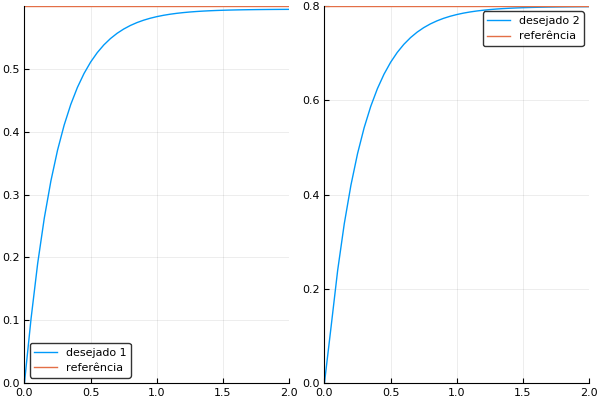

In [12]:
plotx()